# 4. Independent component analysis

In the previous tutorial, we transformed seismic data into scattering coefficients using a scattering network.

Scattering coefficients contain high-level information but in a high-dimensional space that can be cumbersome to analyze. In this tutorial, we use dimensionality reduction techniques to extract the most relevant information into a few key features that are easier to work with and visualize.

> **Note**: This notebook requires the installation of the matplotlib and scikit-learn libraries, which are not included in the default installation of the scatseisnet library. To install them, please visit the [matplotlib website](https://matplotlib.org/stable/users/installing.html) and the [scikit-learn website](https://scikit-learn.org/stable/install.html).

In [9]:
import pickle

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from sklearn.decomposition import FastICA, PCA

plt.rcParams["date.converter"] = "concise"
%config InlineBackend.figure_format = "svg"

## Load scattering coefficients

First, we load the scattering coefficients and reshape them for dimensionality reduction. The scattering coefficients from the previous notebook come in separate arrays for each order, but we need to combine them into a single two-dimensional matrix where each row represents a time segment and each column represents a feature.

In [10]:
# Load data from file
with np.load(
    "../example/scattering_coefficients.npz", allow_pickle=True
) as data:
    order_1 = data["order_1"]
    order_2 = data["order_2"]
    times = data["times"]

# Reshape and stack scattering coefficients of all orders
order_1 = order_1.reshape(order_1.shape[0], -1)
order_2 = order_2.reshape(order_2.shape[0], -1)
scattering_coefficients = np.hstack((order_1, order_2))

# transform into log
scattering_coefficients = np.log10(scattering_coefficients)

# print info about shape
n_times, n_coeff = scattering_coefficients.shape
print("Collected {} samples of {} dimensions each.".format(n_times, n_coeff))

Collected 4319 samples of 504 dimensions each.


## Apply dimensionality reduction

After loading and reorganizing the scattering coefficients into a matrix, we can now apply dimensionality reduction algorithms. We'll explore two complementary approaches: Principal Component Analysis (PCA) and Independent Component Analysis (ICA). Both are linear methods that help us extract the most important patterns from our high-dimensional data, but they work in slightly different ways and can reveal different aspects of the signal structure.

In [11]:
pca_model = PCA(n_components=10, whiten=True)
pca_features = pca_model.fit_transform(scattering_coefficients)

## Visualize PCA features

This is a crucial step in understanding whether the dimensionality reduction is capturing meaningful structure. Look for patterns in the features that correlate with your prior knowledge of the data or with identifiable signal structures. If the features appear random or don't show clear structure, you might need to adjust the number of components or try a different approach.

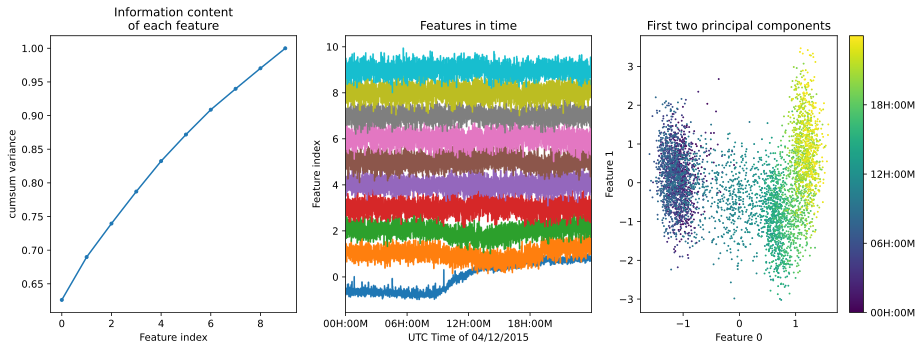

In [12]:
# Normalize features for display
features_normalized = pca_features / np.abs(pca_features).max(axis=0)
myFmt = mdates.DateFormatter("%HH:%MM")

# Figure and axes instance
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=200)

# Plot the cumulative sum of the explained variance ratio of the principal components
axes[0].plot(
    np.cumsum(
        pca_model.explained_variance_ratio_
        / sum(pca_model.explained_variance_ratio_)
    ),
    ".-",
)
axes[0].set_ylabel("cumsum variance")
axes[0].set_xlabel("Feature index")
axes[0].set_title("Information content\nof each feature")

# Plot features in time
axes[1].plot(
    times,
    features_normalized + np.arange(features_normalized.shape[1]),
    rasterized=True,
)
axes[1].set_xlim(times.min(), times.max())
axes[1].xaxis.set_major_formatter(myFmt)
axes[1].xaxis.set_major_locator(mdates.HourLocator(interval=6))
axes[1].set_ylabel("Feature index")
axes[1].set_xlabel("UTC Time of 04/12/2015")
axes[1].set_title("Features in time")


# Plot the first two principal components
mappable = axes[2].scatter(
    pca_features[:, 0], pca_features[:, 1], s=1, c=mdates.date2num(times)
)
axes[2].set_ylabel("Feature 1")
axes[2].set_xlabel("Feature 0")
axes[2].set_title("First two principal components")

cbar_ax = plt.colorbar(mappable)
cbar_ax.ax.set_ylim(times.min(), times.max())
cbar_ax.ax.yaxis.set_major_formatter(myFmt)
cbar_ax.ax.yaxis.set_major_locator(mdates.HourLocator(interval=6))

# Show
plt.show()

#### Interpretation

Each principal component reflects a variance score from the original data, indicating how much information is preserved. In our case, the first principal component (feature 0) represents more than 60 % of the data's variance. The second component (feature 1) explains more than 5 % variance and so on. The time history of feature 0 seems to reflect the time history of the tremor signal in the seismogram. With increasing feature index, the time history appear more random, containing less important information for our task at hand. On the right handside, we show the first two features and color-code the data points with its corresponding timestamp.

## Apply independent component analysis

Independent component analysis (ICA) is another dimensionality reduction technique that separates mixed signals into independent components. Unlike PCA which finds orthogonal directions of maximum variance, ICA finds statistically independent sources.

The PCA analysis showed us that only a few components contain relevant information. We can use that knowledge to set the number of components from 10 to a lower number for the ICA analysis. ICA whitens the data beforehand, so we cannot rank or score the independent components as we did for the principal components. In the following example, we set the number of components to 4, a choice which is mainly guided visually.

The `FastICA` algorithm, included in the `sklearn` package, is one of the most common algorithms to perform ICA. It factorizes the data matrix (in our case scattering coefficient matrix) into an independent source matrix and a mixing matrix. The `n_components` keyword argument informs the model about how many components (or features, or sources) we want to extract. The residual shape of the `features` matrix will be `(n_times, n_components)` instead of the initial scattering coefficients shape shown above. Setting the `random_state` parameter to an integer helps to reproduce the same results, which might be important if you want to test different model parameters.

In [13]:
ica_model = FastICA(n_components=4, whiten="unit-variance", random_state=42)
ica_features = ica_model.fit_transform(scattering_coefficients)

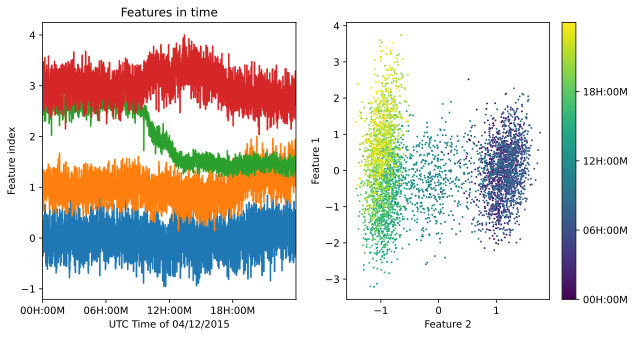

In [14]:
# Normalize features for display
features_normalized = ica_features / np.abs(ica_features).max(axis=0)
myFmt = mdates.DateFormatter("%HH:%MM")

# Figure and axes instance
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=200)

# Plot features in time
axes[0].plot(
    times,
    features_normalized + np.arange(ica_features.shape[1]),
    rasterized=True,
)
axes[0].set_xlim(times.min(), times.max())
axes[0].xaxis.set_major_formatter(myFmt)
axes[0].xaxis.set_major_locator(mdates.HourLocator(interval=6))
axes[0].set_ylabel("Feature index")
axes[0].set_xlabel("UTC Time of 04/12/2015")
axes[0].set_title("Features in time")


# Plot the first two principal components
mappable = axes[1].scatter(
    ica_features[:, 2], ica_features[:, 1], s=1, c=mdates.date2num(times)
)
axes[1].set_ylabel("Feature 1")
axes[1].set_xlabel("Feature 2")

cbar_ax = plt.colorbar(mappable)
cbar_ax.ax.set_ylim(times.min(), times.max())
cbar_ax.ax.yaxis.set_major_formatter(myFmt)
cbar_ax.ax.yaxis.set_major_locator(mdates.HourLocator(interval=6))

# Show
plt.show()

## Interpret ICA results

The 4 features from ICA look similar to the first 4 features of PCA, however the ranking is different. The ranking of ICA has no importance—ICA does not sort its components after an eigenvalue as PCA does. If we do not fix the `random_state` parameter, the ranking and sign of the components might change with each run. On the right, we show the two ICA features which contain similar information to the first two PCA features.

## Save the output

We save the extracted features from the ICA model as a npz-file for other downstream tasks, just like we saved the scattering coefficients in the previous notebook.

In [15]:
# Save the features
np.savez(
    "../example/independent_components.npz",
    features=ica_features,
    times=times,
)

# Save the dimension reduction model
with open("../example/dimension_model.pickle", "wb") as pickle_file:
    pickle.dump(
        ica_model,
        pickle_file,
        protocol=pickle.HIGHEST_PROTOCOL,
    )